In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import PIL
import tensorflow as tf
import pathlib
import pandas as pd
from sklearn.model_selection import train_test_split

In [2]:
# Download data
!pip install -q gdown
!gdown --folder 'https://drive.google.com/drive/folders/1nuVnG-y3I1f3E0GyOa5pRJOuupgLoTdk?usp=sharing'

Retrieving folder contents
Processing file 1EnDteKH2T_IeMty6I0DTVmvrIMJN20e5 labels.csv
Processing file 1eQWMKTZklzSc5x_tUJdGA7ckSdbMucO_ sample_submission.csv
Processing file 1VB60_rCOoteL-k5RlRit7BNyfz74b5QG test.zip
Processing file 1cgPyc3ao0e1pnhyioBRISuRz1QExkfzF train.zip
Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1EnDteKH2T_IeMty6I0DTVmvrIMJN20e5
To: /content/DogBreedData/labels.csv
100% 482k/482k [00:00<00:00, 147MB/s]
Downloading...
From: https://drive.google.com/uc?id=1eQWMKTZklzSc5x_tUJdGA7ckSdbMucO_
To: /content/DogBreedData/sample_submission.csv
100% 25.2M/25.2M [00:00<00:00, 166MB/s] 
Downloading...
From (original): https://drive.google.com/uc?id=1VB60_rCOoteL-k5RlRit7BNyfz74b5QG
From (redirected): https://drive.google.com/uc?id=1VB60_rCOoteL-k5RlRit7BNyfz74b5QG&confirm=t&uuid=3116db47-b0e1-43c3-8cf4-31a636b72d9a
To: /content/DogBreedData/test.zip
100% 363M/36

In [3]:
# Extract and prepare the files
import pathlib

# Unzip directly into parent folder
!unzip -q /content/DogBreedData/train.zip -d /content/DogBreedData/

In [4]:
# Downloading the labels
labels_df = pd.read_csv("/content/DogBreedData/labels.csv")
labels_df.head()

# Create mappings with integer encoding
label_names = sorted(labels_df['breed'].unique())   # All breed names sorted
label_to_index = {name: i for i, name in enumerate(label_names)}
index_to_label = {i: name for name, i in label_to_index.items()}

# Add integer label column
labels_df['label_index'] = labels_df['breed'].map(label_to_index)
labels_df['file_path'] = labels_df['id'].apply(lambda x: str(pathlib.Path("/content/DogBreedData/train/") / f"{x}.jpg"))

# Display a few examples
print("\nExample mapping:")
print(labels_df.head())


Example mapping:
                                 id             breed  label_index  \
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull           19   
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo           37   
2  001cdf01b096e06d78e9e5112d419397          pekinese           85   
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick           15   
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever           49   

                                           file_path  
0  /content/DogBreedData/train/000bec180eb18c7604...  
1  /content/DogBreedData/train/001513dfcb2ffafc82...  
2  /content/DogBreedData/train/001cdf01b096e06d78...  
3  /content/DogBreedData/train/00214f311d5d2247d5...  
4  /content/DogBreedData/train/0021f9ceb3235effd7...  


In [23]:
# Parameters
BATCH_SIZE = 32
IMG_SIZE = (160, 160)
IMG_SHAPE = IMG_SIZE + (3,)
base_learning_rate = 0.0001

In [24]:
# Split into train/validation
train_val_df, test_df = train_test_split(labels_df, test_size=0.15, stratify=labels_df['label_index'], random_state=42)
train_df, val_df = train_test_split(train_val_df, test_size=0.1765, stratify=train_val_df['label_index'], random_state=42)

# Load and preprocess the images
def load_image(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    img = (img / 127.5) - 1  # scale to [-1, 1]
    return img, label

# Convert to tf.data.Datasets
train_ds = tf.data.Dataset.from_tensor_slices((train_df['file_path'], train_df['label_index']))
val_ds = tf.data.Dataset.from_tensor_slices((val_df['file_path'], val_df['label_index']))
test_ds = tf.data.Dataset.from_tensor_slices((test_df['file_path'], test_df['label_index']))

# Map, shuffle, batch, prefetch
train_ds = train_ds.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

train_ds = train_ds.shuffle(1000).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

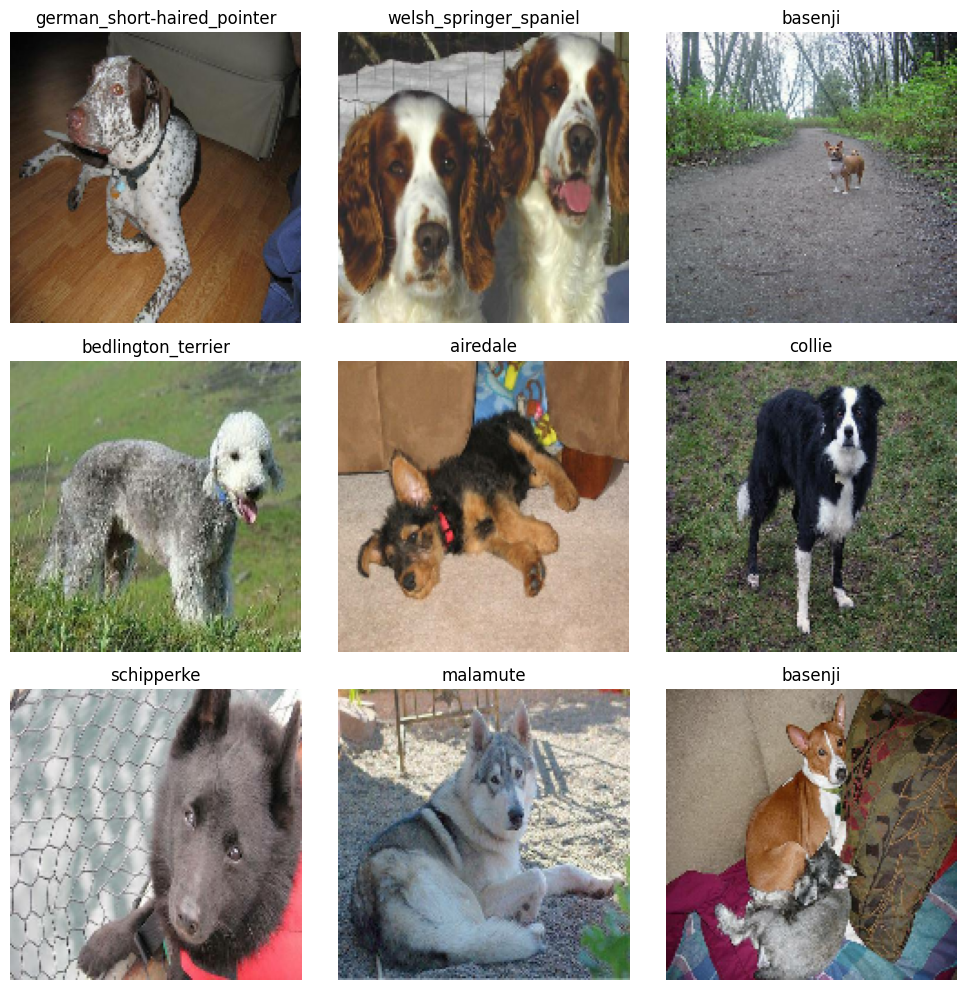

In [25]:
# Visualize the data
for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        img_to_plot = (images[i].numpy() + 1.0) / 2.0  # scale [-1,1] -> [0,1]
        plt.imshow(img_to_plot)
        label_index = int(labels[i].numpy())
        plt.title(index_to_label[label_index])
        plt.axis("off")
    plt.tight_layout()
    plt.show()

In [26]:
# Data Augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2),
])

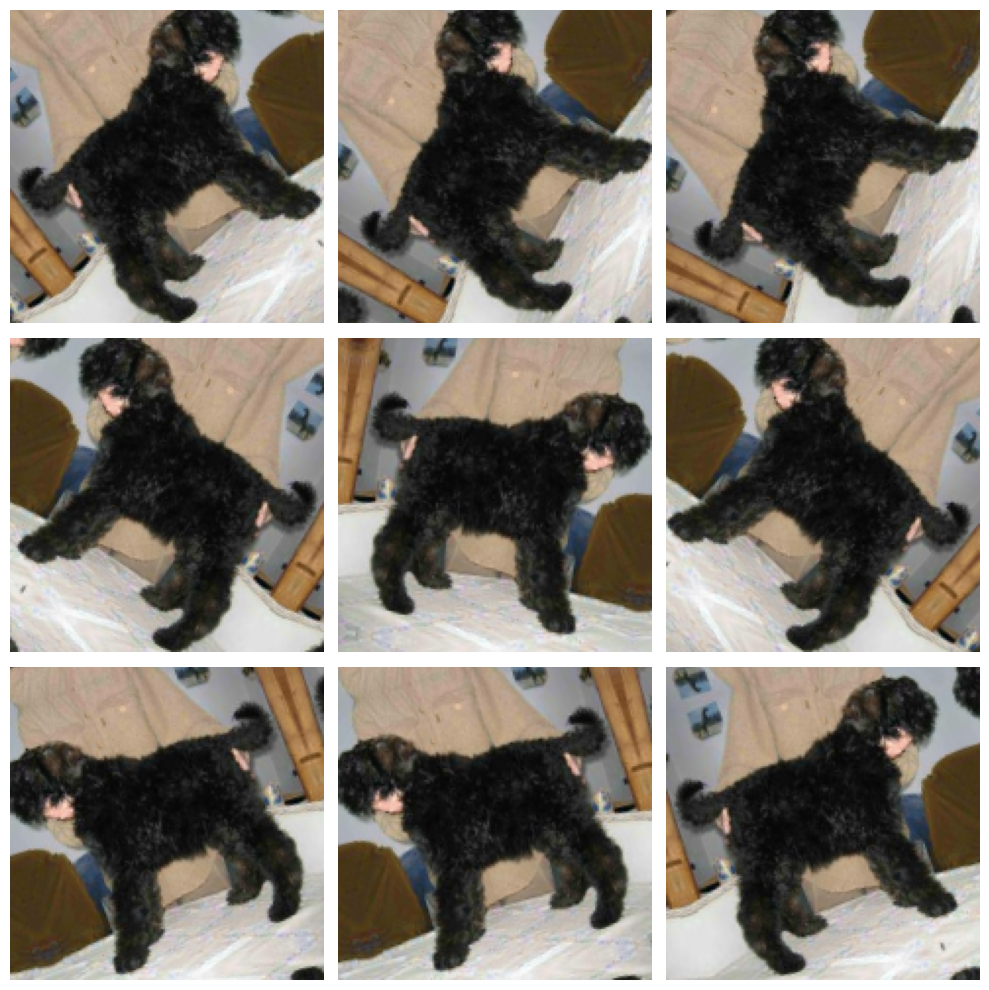

In [27]:
# Look at an image impacted by data augmentation
for image, _ in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        img_to_plot = (augmented_image[0] + 1) / 2  # Convert [-1,1] -> [0,1]
        plt.imshow(img_to_plot)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

In [28]:
param_grid = [
    {'dense_layers': 1, 'units': 128, 'dropout': 0.2, 'fine_tune': True},
    {'dense_layers': 1, 'units': 256, 'dropout': 0.3, 'fine_tune': True},

    {'dense_layers': 2, 'units': 128, 'dropout': 0.2, 'fine_tune': True},
    {'dense_layers': 2, 'units': 256, 'dropout': 0.3, 'fine_tune': True},

    {'dense_layers': 3, 'units': 128, 'dropout': 0.2, 'fine_tune': True},
    {'dense_layers': 3, 'units': 256, 'dropout': 0.3, 'fine_tune': True}
]

records = []
initial_epochs = 5
fine_tune_epochs = 5
total_epochs = initial_epochs + fine_tune_epochs


Experiment 1: {'dense_layers': 1, 'units': 128, 'dropout': 0.2, 'fine_tune': True}
Epoch 1/5
224/224 ━━━━━━━━━━━━━━━━━━━━ 79s 192ms/step - accuracy: 0.0468 - loss: 4.7087 - val_accuracy: 0.2855 - val_loss: 3.0875
Epoch 2/5
224/224 ━━━━━━━━━━━━━━━━━━━━ 42s 184ms/step - accuracy: 0.3235 - loss: 3.0103 - val_accuracy: 0.4941 - val_loss: 1.8708
Epoch 3/5
224/224 ━━━━━━━━━━━━━━━━━━━━ 47s 204ms/step - accuracy: 0.5000 - loss: 1.9553 - val_accuracy: 0.5698 - val_loss: 1.5836
Epoch 4/5
224/224 ━━━━━━━━━━━━━━━━━━━━ 43s 188ms/step - accuracy: 0.5764 - loss: 1.5604 - val_accuracy: 0.5776 - val_loss: 1.5135
Epoch 5/5
224/224 ━━━━━━━━━━━━━━━━━━━━ 42s 183ms/step - accuracy: 0.6257 - loss: 1.3286 - val_accuracy: 0.5821 - val_loss: 1.5116


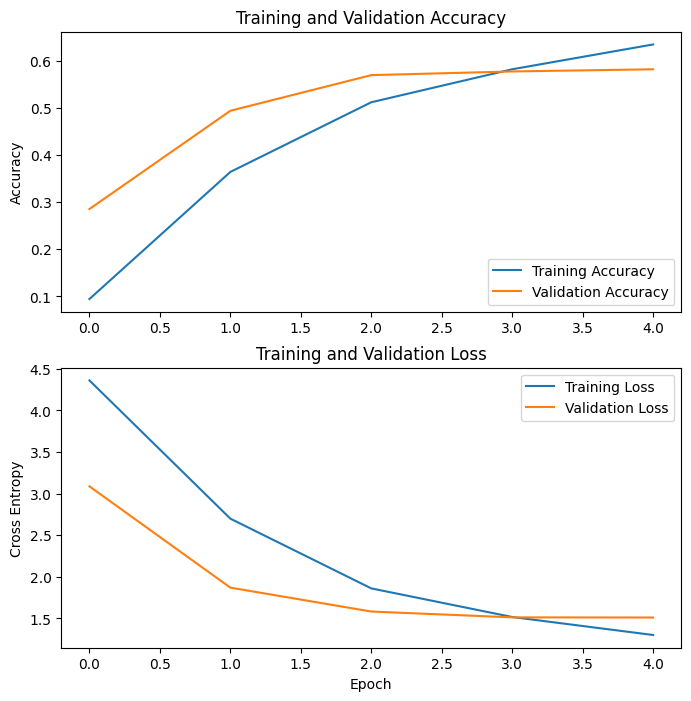

Epoch 5/10
224/224 ━━━━━━━━━━━━━━━━━━━━ 41s 103ms/step - accuracy: 0.6879 - loss: 1.1070 - val_accuracy: 0.6232 - val_loss: 1.3725
Epoch 6/10
224/224 ━━━━━━━━━━━━━━━━━━━━ 23s 91ms/step - accuracy: 0.7071 - loss: 1.0434 - val_accuracy: 0.6343 - val_loss: 1.3238
Epoch 7/10
224/224 ━━━━━━━━━━━━━━━━━━━━ 24s 99ms/step - accuracy: 0.7148 - loss: 0.9916 - val_accuracy: 0.6369 - val_loss: 1.3065
Epoch 8/10
224/224 ━━━━━━━━━━━━━━━━━━━━ 21s 86ms/step - accuracy: 0.7246 - loss: 0.9899 - val_accuracy: 0.6395 - val_loss: 1.2941
Epoch 9/10
224/224 ━━━━━━━━━━━━━━━━━━━━ 19s 82ms/step - accuracy: 0.7108 - loss: 0.9756 - val_accuracy: 0.6362 - val_loss: 1.2914
Epoch 10/10
224/224 ━━━━━━━━━━━━━━━━━━━━ 22s 89ms/step - accuracy: 0.7412 - loss: 0.9115 - val_accuracy: 0.6389 - val_loss: 1.2974


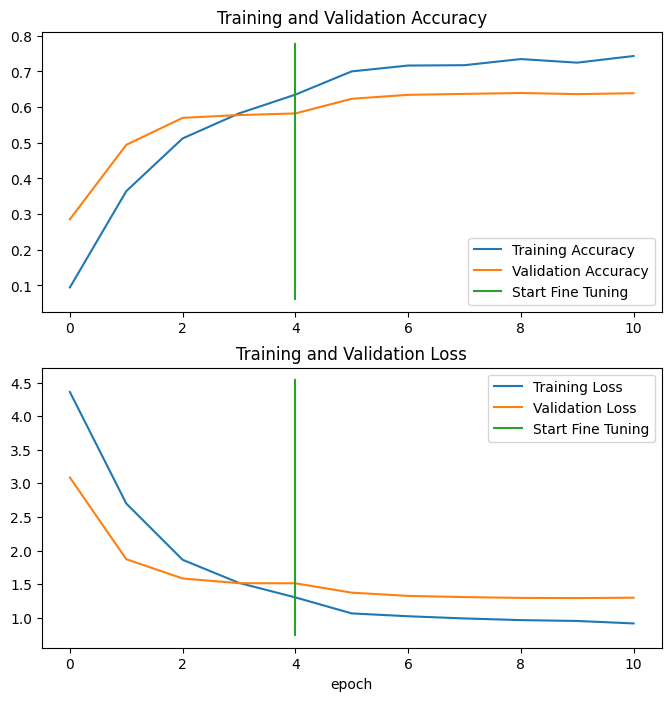


Experiment 2: {'dense_layers': 1, 'units': 256, 'dropout': 0.3, 'fine_tune': True}
Epoch 1/5
224/224 ━━━━━━━━━━━━━━━━━━━━ 77s 204ms/step - accuracy: 0.0403 - loss: 4.7517 - val_accuracy: 0.3331 - val_loss: 2.7955
Epoch 2/5
224/224 ━━━━━━━━━━━━━━━━━━━━ 45s 195ms/step - accuracy: 0.3453 - loss: 2.7795 - val_accuracy: 0.4915 - val_loss: 1.8580
Epoch 3/5
224/224 ━━━━━━━━━━━━━━━━━━━━ 44s 190ms/step - accuracy: 0.4908 - loss: 1.8517 - val_accuracy: 0.5567 - val_loss: 1.5457
Epoch 4/5
224/224 ━━━━━━━━━━━━━━━━━━━━ 44s 193ms/step - accuracy: 0.5781 - loss: 1.4830 - val_accuracy: 0.6043 - val_loss: 1.4269
Epoch 5/5
224/224 ━━━━━━━━━━━━━━━━━━━━ 44s 191ms/step - accuracy: 0.6282 - loss: 1.2720 - val_accuracy: 0.6206 - val_loss: 1.3696


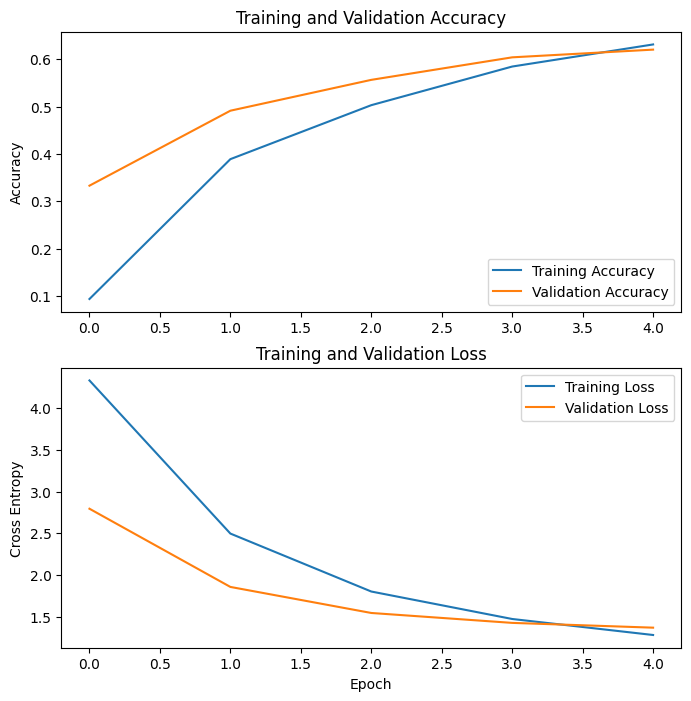

Epoch 5/10
224/224 ━━━━━━━━━━━━━━━━━━━━ 40s 110ms/step - accuracy: 0.6944 - loss: 1.0739 - val_accuracy: 0.6402 - val_loss: 1.2932
Epoch 6/10
224/224 ━━━━━━━━━━━━━━━━━━━━ 25s 106ms/step - accuracy: 0.7129 - loss: 1.0030 - val_accuracy: 0.6493 - val_loss: 1.2692
Epoch 7/10
224/224 ━━━━━━━━━━━━━━━━━━━━ 39s 96ms/step - accuracy: 0.7105 - loss: 1.0120 - val_accuracy: 0.6415 - val_loss: 1.2598
Epoch 8/10
224/224 ━━━━━━━━━━━━━━━━━━━━ 23s 95ms/step - accuracy: 0.7242 - loss: 0.9643 - val_accuracy: 0.6473 - val_loss: 1.2472
Epoch 9/10
224/224 ━━━━━━━━━━━━━━━━━━━━ 38s 84ms/step - accuracy: 0.7372 - loss: 0.9295 - val_accuracy: 0.6486 - val_loss: 1.2480
Epoch 10/10
224/224 ━━━━━━━━━━━━━━━━━━━━ 20s 85ms/step - accuracy: 0.7251 - loss: 0.9206 - val_accuracy: 0.6447 - val_loss: 1.2549


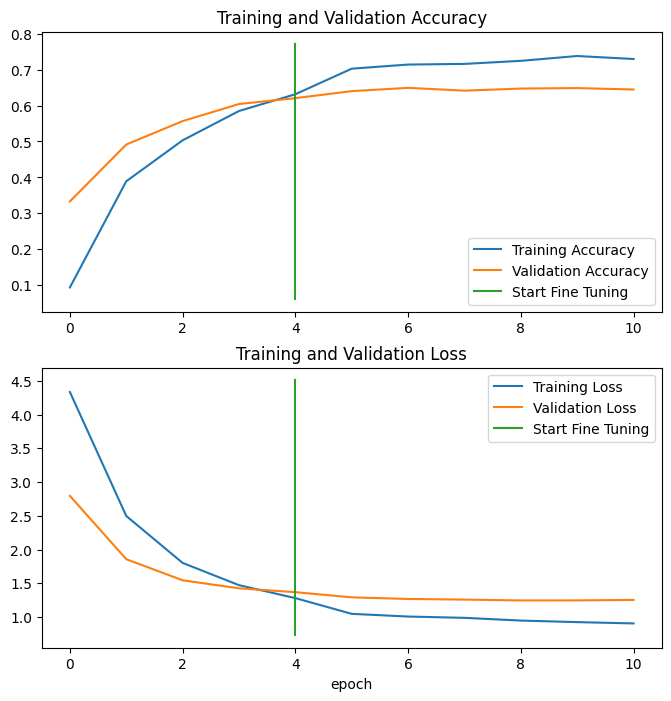


Experiment 3: {'dense_layers': 2, 'units': 128, 'dropout': 0.2, 'fine_tune': True}
Epoch 1/5
224/224 ━━━━━━━━━━━━━━━━━━━━ 81s 195ms/step - accuracy: 0.0238 - loss: 4.7604 - val_accuracy: 0.1877 - val_loss: 3.6829
Epoch 2/5
224/224 ━━━━━━━━━━━━━━━━━━━━ 42s 185ms/step - accuracy: 0.2320 - loss: 3.4973 - val_accuracy: 0.4198 - val_loss: 2.2902
Epoch 3/5
224/224 ━━━━━━━━━━━━━━━━━━━━ 45s 193ms/step - accuracy: 0.4572 - loss: 2.1669 - val_accuracy: 0.4844 - val_loss: 1.9653
Epoch 4/5
224/224 ━━━━━━━━━━━━━━━━━━━━ 45s 194ms/step - accuracy: 0.5457 - loss: 1.6624 - val_accuracy: 0.5248 - val_loss: 1.7826
Epoch 5/5
224/224 ━━━━━━━━━━━━━━━━━━━━ 42s 180ms/step - accuracy: 0.6141 - loss: 1.4150 - val_accuracy: 0.5424 - val_loss: 1.6762


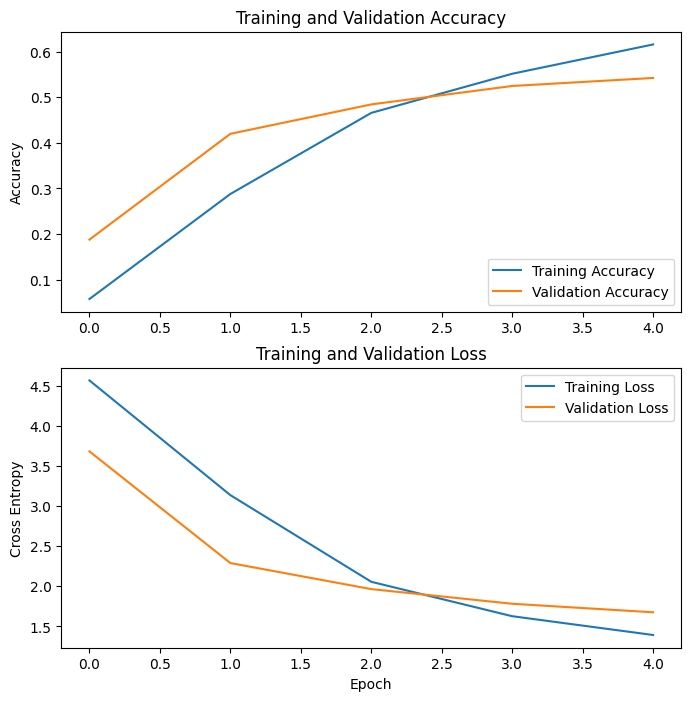

Epoch 5/10
224/224 ━━━━━━━━━━━━━━━━━━━━ 43s 110ms/step - accuracy: 0.6657 - loss: 1.2103 - val_accuracy: 0.5815 - val_loss: 1.5697
Epoch 6/10
224/224 ━━━━━━━━━━━━━━━━━━━━ 24s 100ms/step - accuracy: 0.6752 - loss: 1.1419 - val_accuracy: 0.5828 - val_loss: 1.5023
Epoch 7/10
224/224 ━━━━━━━━━━━━━━━━━━━━ 24s 97ms/step - accuracy: 0.7014 - loss: 1.0723 - val_accuracy: 0.5991 - val_loss: 1.4684
Epoch 8/10
224/224 ━━━━━━━━━━━━━━━━━━━━ 24s 99ms/step - accuracy: 0.6959 - loss: 1.0788 - val_accuracy: 0.6069 - val_loss: 1.4389
Epoch 9/10
224/224 ━━━━━━━━━━━━━━━━━━━━ 21s 89ms/step - accuracy: 0.7174 - loss: 1.0336 - val_accuracy: 0.6010 - val_loss: 1.4353
Epoch 10/10
224/224 ━━━━━━━━━━━━━━━━━━━━ 26s 112ms/step - accuracy: 0.7221 - loss: 0.9978 - val_accuracy: 0.6089 - val_loss: 1.4243


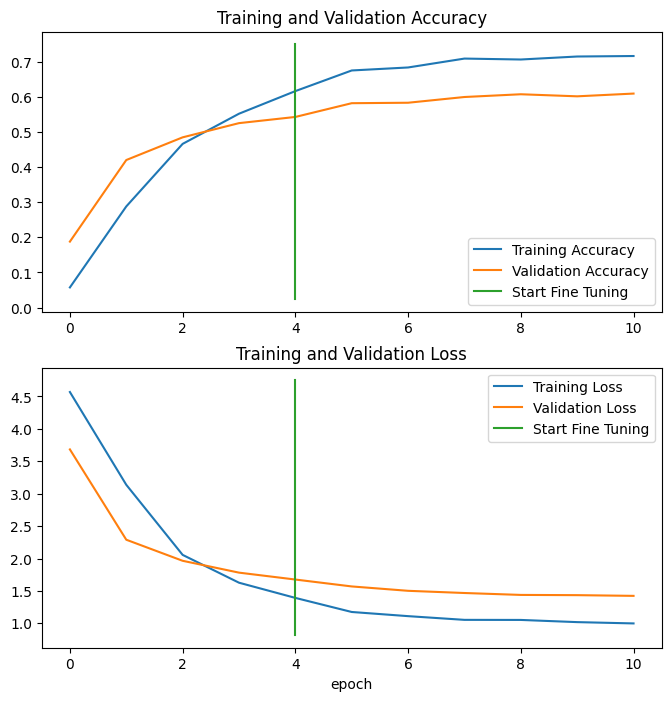


Experiment 4: {'dense_layers': 2, 'units': 256, 'dropout': 0.3, 'fine_tune': True}
Epoch 1/5
224/224 ━━━━━━━━━━━━━━━━━━━━ 84s 210ms/step - accuracy: 0.0352 - loss: 4.7085 - val_accuracy: 0.2445 - val_loss: 3.1682
Epoch 2/5
224/224 ━━━━━━━━━━━━━━━━━━━━ 80s 200ms/step - accuracy: 0.2916 - loss: 3.0524 - val_accuracy: 0.4954 - val_loss: 1.8400
Epoch 3/5
224/224 ━━━━━━━━━━━━━━━━━━━━ 43s 186ms/step - accuracy: 0.4809 - loss: 1.9363 - val_accuracy: 0.5476 - val_loss: 1.6702
Epoch 4/5
224/224 ━━━━━━━━━━━━━━━━━━━━ 46s 198ms/step - accuracy: 0.5544 - loss: 1.5667 - val_accuracy: 0.5372 - val_loss: 1.6815
Epoch 5/5
224/224 ━━━━━━━━━━━━━━━━━━━━ 44s 190ms/step - accuracy: 0.6181 - loss: 1.3463 - val_accuracy: 0.5698 - val_loss: 1.5922


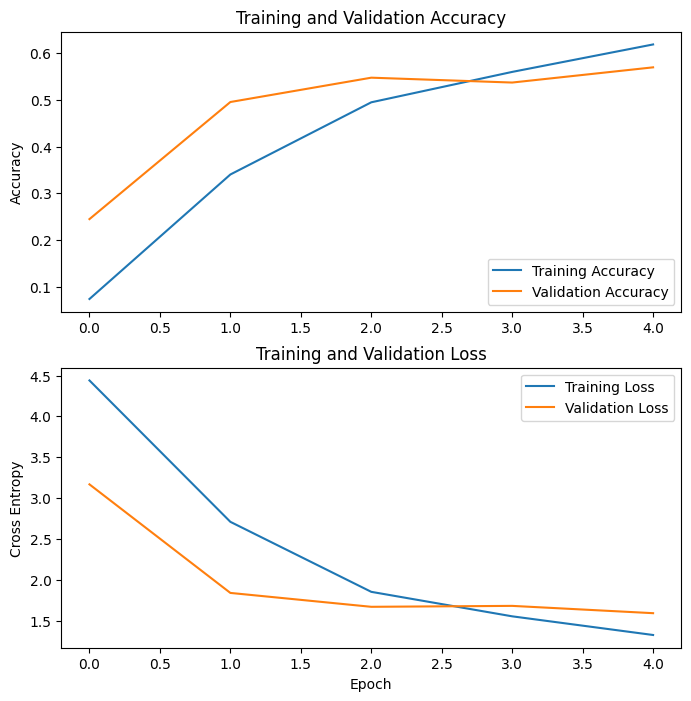

Epoch 5/10
224/224 ━━━━━━━━━━━━━━━━━━━━ 40s 114ms/step - accuracy: 0.6778 - loss: 1.1447 - val_accuracy: 0.6115 - val_loss: 1.3873
Epoch 6/10
224/224 ━━━━━━━━━━━━━━━━━━━━ 25s 104ms/step - accuracy: 0.6928 - loss: 1.0629 - val_accuracy: 0.6199 - val_loss: 1.3390
Epoch 7/10
224/224 ━━━━━━━━━━━━━━━━━━━━ 23s 98ms/step - accuracy: 0.7066 - loss: 0.9916 - val_accuracy: 0.6278 - val_loss: 1.3169
Epoch 8/10
224/224 ━━━━━━━━━━━━━━━━━━━━ 24s 99ms/step - accuracy: 0.7165 - loss: 0.9598 - val_accuracy: 0.6375 - val_loss: 1.3106
Epoch 9/10
224/224 ━━━━━━━━━━━━━━━━━━━━ 24s 100ms/step - accuracy: 0.7111 - loss: 0.9898 - val_accuracy: 0.6402 - val_loss: 1.3085
Epoch 10/10
224/224 ━━━━━━━━━━━━━━━━━━━━ 23s 98ms/step - accuracy: 0.7326 - loss: 0.9333 - val_accuracy: 0.6382 - val_loss: 1.3174


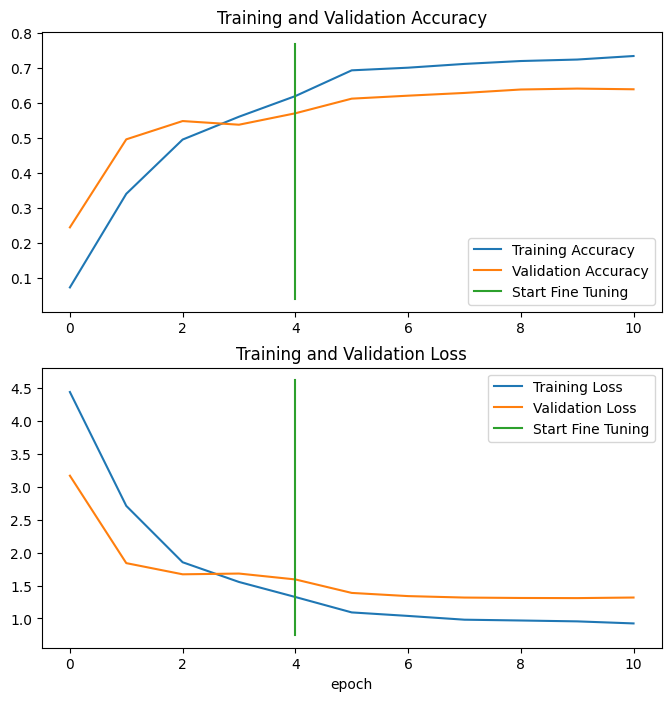


Experiment 5: {'dense_layers': 3, 'units': 128, 'dropout': 0.2, 'fine_tune': True}
Epoch 1/5
224/224 ━━━━━━━━━━━━━━━━━━━━ 85s 203ms/step - accuracy: 0.0226 - loss: 4.7461 - val_accuracy: 0.1649 - val_loss: 3.9426
Epoch 2/5
224/224 ━━━━━━━━━━━━━━━━━━━━ 44s 192ms/step - accuracy: 0.1875 - loss: 3.7235 - val_accuracy: 0.3735 - val_loss: 2.3573
Epoch 3/5
224/224 ━━━━━━━━━━━━━━━━━━━━ 45s 197ms/step - accuracy: 0.4108 - loss: 2.3314 - val_accuracy: 0.4817 - val_loss: 1.9213
Epoch 4/5
224/224 ━━━━━━━━━━━━━━━━━━━━ 81s 187ms/step - accuracy: 0.5094 - loss: 1.8021 - val_accuracy: 0.4922 - val_loss: 1.8785
Epoch 5/5
224/224 ━━━━━━━━━━━━━━━━━━━━ 46s 201ms/step - accuracy: 0.5806 - loss: 1.5327 - val_accuracy: 0.5137 - val_loss: 1.8434


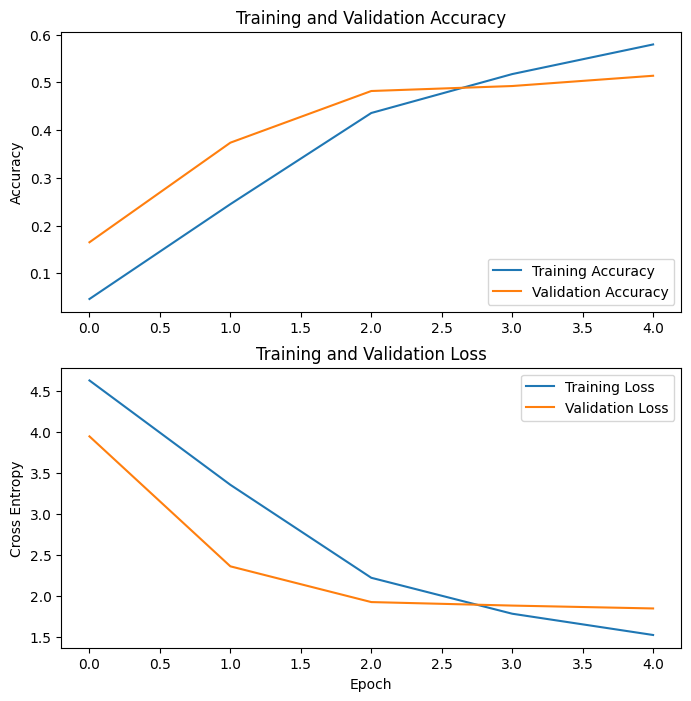

Epoch 5/10
224/224 ━━━━━━━━━━━━━━━━━━━━ 42s 100ms/step - accuracy: 0.6476 - loss: 1.2564 - val_accuracy: 0.5632 - val_loss: 1.6342
Epoch 6/10
224/224 ━━━━━━━━━━━━━━━━━━━━ 38s 90ms/step - accuracy: 0.6649 - loss: 1.1881 - val_accuracy: 0.5893 - val_loss: 1.5523
Epoch 7/10
224/224 ━━━━━━━━━━━━━━━━━━━━ 25s 102ms/step - accuracy: 0.6789 - loss: 1.1349 - val_accuracy: 0.5984 - val_loss: 1.4964
Epoch 8/10
224/224 ━━━━━━━━━━━━━━━━━━━━ 24s 99ms/step - accuracy: 0.6839 - loss: 1.1208 - val_accuracy: 0.6017 - val_loss: 1.4703
Epoch 9/10
224/224 ━━━━━━━━━━━━━━━━━━━━ 25s 104ms/step - accuracy: 0.6915 - loss: 1.0697 - val_accuracy: 0.6102 - val_loss: 1.4596
Epoch 10/10
224/224 ━━━━━━━━━━━━━━━━━━━━ 25s 104ms/step - accuracy: 0.7007 - loss: 1.0534 - val_accuracy: 0.6082 - val_loss: 1.4409


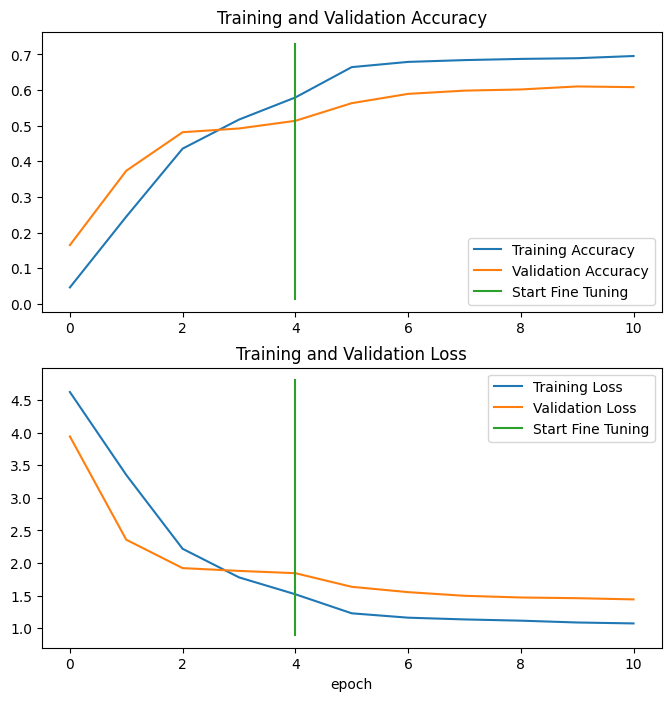


Experiment 6: {'dense_layers': 3, 'units': 256, 'dropout': 0.3, 'fine_tune': True}
Epoch 1/5
224/224 ━━━━━━━━━━━━━━━━━━━━ 74s 187ms/step - accuracy: 0.0263 - loss: 4.7339 - val_accuracy: 0.2093 - val_loss: 3.3924
Epoch 2/5
224/224 ━━━━━━━━━━━━━━━━━━━━ 41s 177ms/step - accuracy: 0.2602 - loss: 3.1872 - val_accuracy: 0.4316 - val_loss: 2.0348
Epoch 3/5
224/224 ━━━━━━━━━━━━━━━━━━━━ 45s 195ms/step - accuracy: 0.4684 - loss: 1.9673 - val_accuracy: 0.5117 - val_loss: 1.7706
Epoch 4/5
224/224 ━━━━━━━━━━━━━━━━━━━━ 45s 196ms/step - accuracy: 0.5583 - loss: 1.5719 - val_accuracy: 0.5274 - val_loss: 1.7213
Epoch 5/5
224/224 ━━━━━━━━━━━━━━━━━━━━ 43s 184ms/step - accuracy: 0.6021 - loss: 1.3838 - val_accuracy: 0.5254 - val_loss: 1.7392


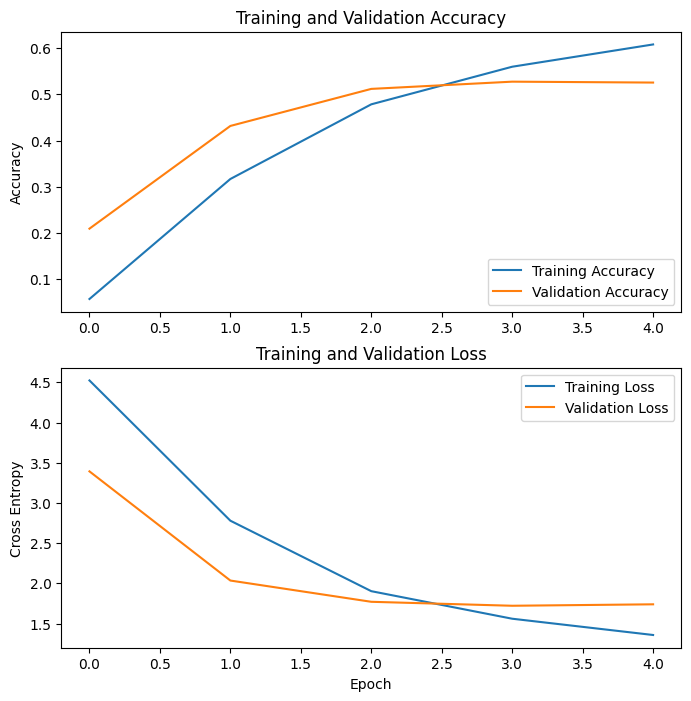

Epoch 5/10
224/224 ━━━━━━━━━━━━━━━━━━━━ 36s 92ms/step - accuracy: 0.6614 - loss: 1.1520 - val_accuracy: 0.5691 - val_loss: 1.5136
Epoch 6/10
224/224 ━━━━━━━━━━━━━━━━━━━━ 40s 86ms/step - accuracy: 0.6957 - loss: 1.0516 - val_accuracy: 0.5997 - val_loss: 1.4183
Epoch 7/10
224/224 ━━━━━━━━━━━━━━━━━━━━ 20s 85ms/step - accuracy: 0.6802 - loss: 1.0431 - val_accuracy: 0.6095 - val_loss: 1.3738
Epoch 8/10
224/224 ━━━━━━━━━━━━━━━━━━━━ 21s 84ms/step - accuracy: 0.7095 - loss: 1.0125 - val_accuracy: 0.6154 - val_loss: 1.3403
Epoch 9/10
224/224 ━━━━━━━━━━━━━━━━━━━━ 20s 84ms/step - accuracy: 0.7062 - loss: 0.9917 - val_accuracy: 0.6219 - val_loss: 1.3189
Epoch 10/10
224/224 ━━━━━━━━━━━━━━━━━━━━ 19s 81ms/step - accuracy: 0.7053 - loss: 0.9896 - val_accuracy: 0.6304 - val_loss: 1.3117


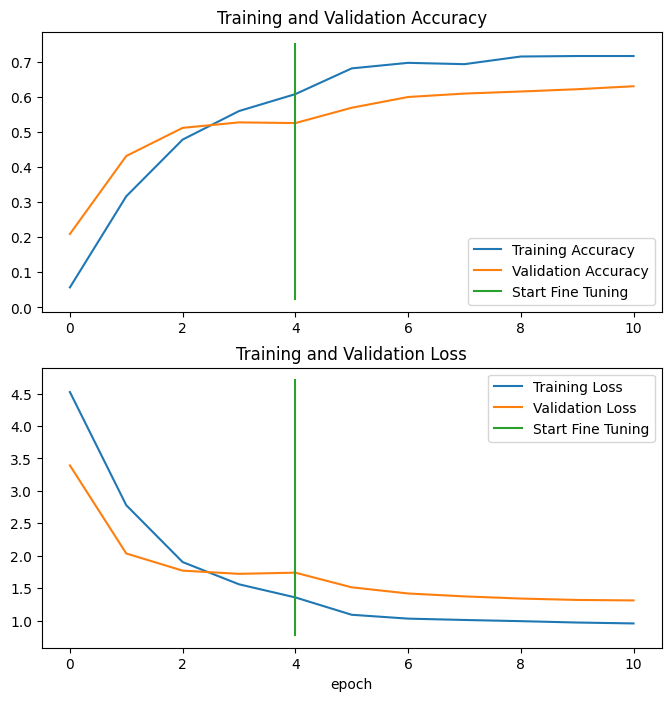

In [29]:
# Hyperparameter tuning loop
for i, params in enumerate(param_grid):
    print(f"\nExperiment {i+1}: {params}")

    # Load base model
    base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                                   include_top=False,
                                                   weights='imagenet')
    base_model.trainable = params['fine_tune']

    # Build top layers
    inputs = tf.keras.Input(shape=IMG_SHAPE)
    x = data_augmentation(inputs)
    x = base_model(x, training=False)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(params['dropout'])(x)

    for _ in range(params['dense_layers']):
        x = tf.keras.layers.Dense(params['units'], activation='relu')(x)
    outputs = tf.keras.layers.Dense(len(label_names), activation='softmax')(x)

    model = tf.keras.Model(inputs, outputs)

    # Compile
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        metrics=['accuracy'])

    # Train
    history = model.fit(train_ds, validation_data=val_ds, epochs=initial_epochs)

    # Evaluate
    train_loss, train_acc = model.evaluate(train_ds, verbose=0)
    val_loss, val_acc = model.evaluate(val_ds, verbose=0)
    test_loss, test_acc = model.evaluate(test_ds, verbose=0)

    # Record results
    record = {**params,
              'train_acc': train_acc, 'train_loss': train_loss,
              'val_acc': val_acc, 'val_loss': val_loss,
              'test_acc': test_acc, 'test_loss': test_loss}
    records.append(record)

    # Plotting metrics
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.xlabel('Epoch')
    plt.title('Training and Validation Loss')
    plt.show()

    # Fine-tuning
    base_model.trainable = True

    # Optional: freeze earlier layers
    for layer in base_model.layers[:100]:
      layer.trainable = False

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate / 10),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        metrics=['accuracy'])

    history_fine = model.fit(train_ds, validation_data=val_ds, epochs=total_epochs, initial_epoch=history.epoch[-1])

    # Update metrics
    acc += history_fine.history['accuracy']
    val_acc += history_fine.history['val_accuracy']
    loss += history_fine.history['loss']
    val_loss += history_fine.history['val_loss']

    # Visualize metrics
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1,initial_epochs-1],
      plt.ylim(), label='Start Fine Tuning')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1,initial_epochs-1],
      plt.ylim(), label='Start Fine Tuning')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()


48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step


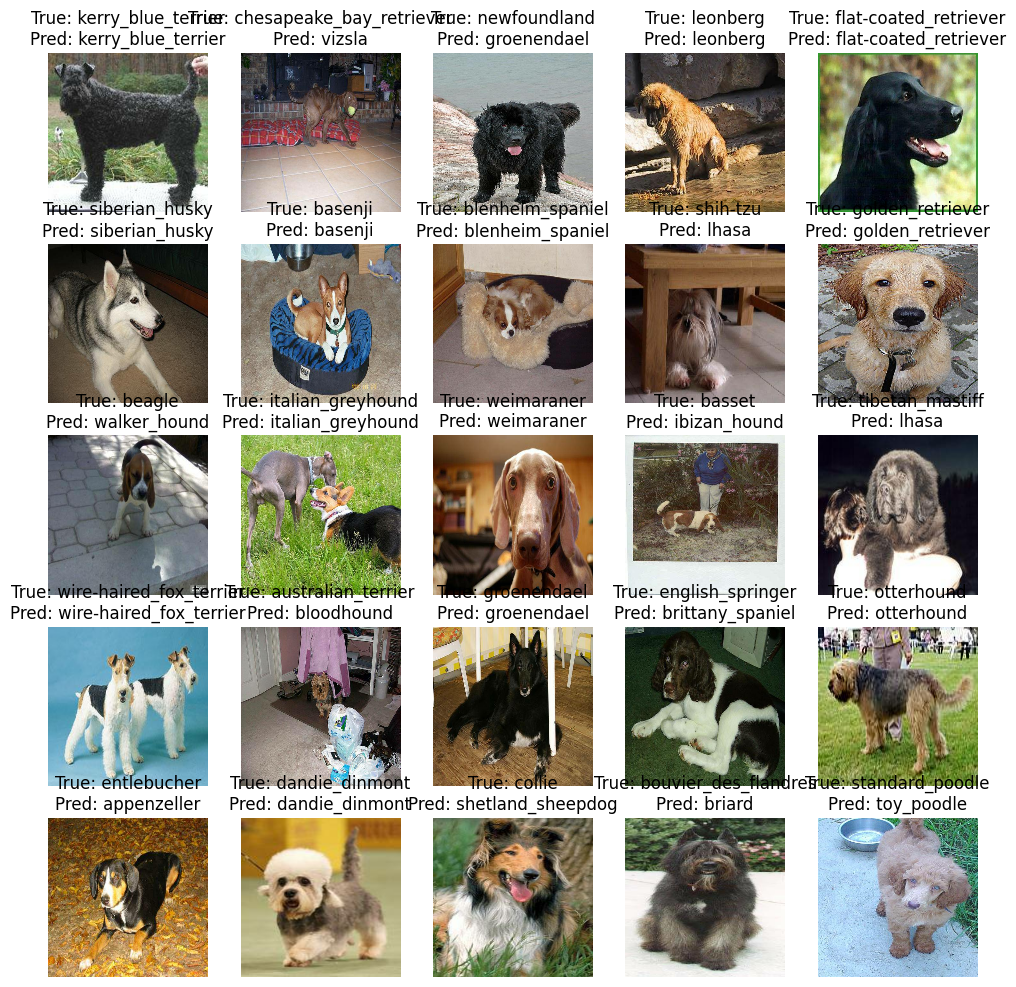

In [44]:
# Show 25 test examples with predicted vs true labels
pred_probs = model.predict(test_ds)
pred_classes = np.argmax(pred_probs, axis=1)
true_classes = np.concatenate([y for x, y in test_ds], axis=0)
pred_labels = [index_to_label[i] for i in pred_classes]
true_labels = [index_to_label[i] for i in true_classes]

plt.figure(figsize=(12,12))
for i, path in enumerate(test_df['file_path'][:25]):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    img = img.numpy().astype("uint8")

    ax = plt.subplot(5,5,i+1)
    plt.imshow(img)
    plt.title(f"True: {true_labels[i]}\nPred: {pred_labels[i]}")
    plt.axis('off')
plt.show()


In [45]:
# Table of parameter testing and tuning
records_df = pd.DataFrame(records)
print("\nHyperparameter tuning results:")
print(records_df)


Hyperparameter tuning results:
   dense_layers  units  dropout  fine_tune  train_acc  train_loss   val_acc  \
0             1    128      0.2       True   0.730920    0.928943  0.582138   
1             1    256      0.3       True   0.762510    0.784002  0.620600   
2             2    128      0.2       True   0.701006    1.018764  0.542373   
3             2    256      0.3       True   0.697372    1.000900  0.569752   
4             3    128      0.2       True   0.629298    1.303396  0.513690   
5             3    256      0.3       True   0.654878    1.136724  0.525424   

   val_loss  test_acc  test_loss  
0  1.511620  0.576271   1.479261  
1  1.369571  0.614081   1.349287  
2  1.676160  0.559974   1.583040  
3  1.592198  0.563233   1.581486  
4  1.843429  0.503911   1.908461  
5  1.739226  0.518253   1.694569  


In [46]:
from tabulate import tabulate

# --- Create a comprehensive table with all metrics ---
report_df_full = records_df.copy()

# Convert accuracies to percentages and round, round losses
for col in ['train_acc', 'val_acc', 'test_acc']:
    report_df_full[col] = (report_df_full[col] * 100).round(1)
for col in ['train_loss', 'val_loss', 'test_loss']:
    report_df_full[col] = report_df_full[col].round(3)

# Select and rename columns for clarity
report_df_full = report_df_full[['dense_layers', 'units', 'dropout', 'fine_tune',
                                 'train_acc', 'train_loss', 'val_acc', 'val_loss', 'test_acc', 'test_loss']]
report_df_full.columns = ['Number of Dense Layers', 'Units per Layer', 'Dropout', 'Fine-tune',
                          'Train Accuracy (%)', 'Train Loss',
                          'Validation Accuracy (%)', 'Validation Loss',
                          'Test Accuracy (%)', 'Test Loss']

# Add iteration numbers
report_df_full.insert(0, 'Iteration', range(1, len(report_df_full)+1))

# --- Print table nicely using tabulate ---
df_to_print = report_df_full.copy()
# Optional: re-round for extra safety/consistency
for col in ['Train Accuracy (%)', 'Validation Accuracy (%)', 'Test Accuracy (%)']:
    df_to_print[col] = df_to_print[col].round(1)
for col in ['Train Loss', 'Validation Loss', 'Test Loss']:
    df_to_print[col] = df_to_print[col].round(3)

# Print the table
print(tabulate(df_to_print, headers='keys', tablefmt='grid', showindex=False))


+-------------+--------------------------+-------------------+-----------+-------------+----------------------+--------------+---------------------------+-------------------+---------------------+-------------+
|   Iteration |   Number of Dense Layers |   Units per Layer |   Dropout | Fine-tune   |   Train Accuracy (%) |   Train Loss |   Validation Accuracy (%) |   Validation Loss |   Test Accuracy (%) |   Test Loss |
+=============+==========================+===================+===========+=============+======================+==============+===========================+===================+=====================+=============+
|           1 |                        1 |               128 |       0.2 | True        |                 73.1 |        0.929 |                      58.2 |             1.512 |                57.6 |       1.479 |
+-------------+--------------------------+-------------------+-----------+-------------+----------------------+--------------+---------------------------+--